# A3C (Asynchronous Advantage Actor-Critic)
### Solving `Pendulum-v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 15th, 2024

In [1]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow_probability as tfp
import gym
from multiprocessing import cpu_count
import threading
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.17.0
tfp 0.24.0
gym 0.26.0
numpy 1.26.4


In [3]:
# Environment setup
env = gym.make('Pendulum-v1')
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.shape[0]
action_bound = [env.action_space.low, env.action_space.high]

# Hyperparameters
num_workers = 8 # cpu_count()
num_episodes = 2000
num_timesteps = 200
global_net_scope = 'Global_Net'
update_global = 10
gamma = 0.90
beta = 0.01

## A3C algorithm

<center>
<img src="a3c_dong.png" alt="A3C" width=500/>
</center>


In [4]:
class ActorNetwork(tf.keras.Model):
    def __init__(self):
        super(ActorNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(200, activation='relu')
        self.mean = tf.keras.layers.Dense(action_shape, activation='tanh')
        self.variance = tf.keras.layers.Dense(action_shape, activation='softplus')
        
    def call(self, state):
        x = self.dense1(state)
        mean = self.mean(x)
        variance = self.variance(x)
        return mean, variance

In [5]:
class CriticNetwork(tf.keras.Model):
    def __init__(self):
        super(CriticNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.value = tf.keras.layers.Dense(1)
        
    def call(self, state):
        x = self.dense1(state)
        value = self.value(x)
        return value

In [6]:
class ActorCritic:
    def __init__(self, scope, global_ac=None):
        self.scope = scope
        
        # Initialize networks by calling them once
        dummy_state = tf.zeros([1, state_shape])
        
        self.actor = ActorNetwork()
        self.actor(dummy_state)  # Build the model
        
        self.critic = CriticNetwork()
        self.critic(dummy_state)  # Build the model
        
        # Optimizers
        self.actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
        self.critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        
        if global_ac is not None:  # For worker networks
            self.global_actor = global_ac.actor
            self.global_critic = global_ac.critic
    
    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        mean, variance = self.actor(state)
        mean = mean * action_bound[1]
        variance = variance + 1e-4
        
        normal_dist = tf.random.normal(shape=mean.shape)
        action = mean + tf.sqrt(variance) * normal_dist
        action = tf.clip_by_value(action, action_bound[0], action_bound[1])
        
        return action[0]
    
    def update(self, states, actions, target_values):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        target_values = tf.convert_to_tensor(target_values, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            # Actor forward pass
            mean, variance = self.actor(states)
            mean = mean * action_bound[1]
            variance = variance + 1e-4
            
            # Create normal distribution
            dist = tfp.distributions.Normal(mean, tf.sqrt(variance))
            log_prob = tf.reduce_sum(dist.log_prob(actions), axis=1, keepdims=True)
            entropy = tf.reduce_sum(dist.entropy(), axis=1, keepdims=True)
            
            # Critic forward pass
            values = self.critic(states)
            td_error = target_values - values
            
            # Define losses
            actor_loss = -tf.reduce_mean(log_prob * tf.stop_gradient(td_error) + beta * entropy)
            critic_loss = tf.reduce_mean(tf.square(td_error))
        
        # Compute gradients
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        
        # Clip gradients
        actor_grads = [tf.clip_by_norm(grad, 40) for grad in actor_grads if grad is not None]
        critic_grads = [tf.clip_by_norm(grad, 40) for grad in critic_grads if grad is not None]
        
        # Create gradient-variable pairs
        actor_grad_vars = list(zip(actor_grads, self.global_actor.trainable_variables))
        critic_grad_vars = list(zip(critic_grads, self.global_critic.trainable_variables))
        
        # Apply gradients if they exist
        if actor_grad_vars:
            self.actor_optimizer.apply_gradients(actor_grad_vars)
        if critic_grad_vars:
            self.critic_optimizer.apply_gradients(critic_grad_vars)
        
        # Update local network
        self.pull_from_global()
        
    def pull_from_global(self):
        for l, g in zip(self.actor.variables, self.global_actor.variables):
            l.assign(g)
        for l, g in zip(self.critic.variables, self.global_critic.variables):
            l.assign(g)

In [7]:
class Worker:
    def __init__(self, name, global_ac):
        self.env = gym.make('Pendulum-v1')
        self.name = name
        self.AC = ActorCritic(name, global_ac)
    
    def work(self):
        global global_rewards, global_episodes
        total_step = 1
        
        while global_episodes < num_episodes:
            state, _ = self.env.reset()
            batch_states, batch_actions, batch_rewards = [], [], []
            Return = 0
            
            for t in range(num_timesteps):               
                action = self.AC.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                
                done = True if t == num_timesteps - 1 else False
                Return += reward
                
                batch_states.append(state)
                batch_actions.append(action)
                batch_rewards.append(reward)
                
                if total_step % update_global == 0 or done:
                    if done:
                        target = 0
                    else:
                        target = self.AC.critic(tf.convert_to_tensor([next_state], dtype=tf.float32))
                        target = target.numpy()[0, 0]
                    
                    batch_target_value = []
                    for reward in batch_rewards[::-1]:
                        target = reward + gamma * target
                        batch_target_value.append(target)
                    batch_target_value.reverse()
                    
                    self.AC.update(np.vstack(batch_states),
                                   np.vstack(batch_actions),
                                   np.vstack(batch_target_value))
                    
                    batch_states, batch_actions, batch_rewards = [], [], []
                
                state = next_state
                total_step += 1
                
                if done:
                    global_rewards.append(Return)
                    global_episodes += 1
                    if (global_episodes+1) % 10 == 0:
                        print(
                            self.name,
                            "Epispde:", global_episodes+1,
                            "| Reward: %i" % global_rewards[-1]
                            )
                    break

## Main
> **TODO:** Log actor and critic losses.

In [8]:
# Training setup
global_rewards = []
global_episodes = 0

# Initialize networks
global_ac = ActorCritic(global_net_scope)
workers = [Worker(f'W_{i}', global_ac) for i in range(num_workers)]

# Start worker threads
worker_threads = []
for worker in workers:
    thread = threading.Thread(target=worker.work)
    thread.start()
    worker_threads.append(thread)

# Wait for all threads to complete
for thread in worker_threads:
    thread.join()

C:\Users\Victus\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


W_7 Epispde: 10 | Reward: -1407 | Actor loss: 24.122211 | Critic loss: 346.35553
W_3 Epispde: 20 | Reward: -1509 | Actor loss: -1.9975342 | Critic loss: 451.5066
W_3 Epispde: 30 | Reward: -1518 | Actor loss: 38.691612 | Critic loss: 970.02814
W_4 Epispde: 40 | Reward: -1495 | Actor loss: 49.412174 | Critic loss: 1218.8499
W_7 Epispde: 50 | Reward: -1486 | Actor loss: 61.77642 | Critic loss: 2126.7793
W_7 Epispde: 60 | Reward: -1509 | Actor loss: 65.19572 | Critic loss: 2236.9172
W_5 Epispde: 70 | Reward: -1405 | Actor loss: 82.72346 | Critic loss: 2569.899
W_4 Epispde: 80 | Reward: -1392 | Actor loss: 96.38158 | Critic loss: 3541.5808
W_7 Epispde: 90 | Reward: -1617 | Actor loss: 30.073772 | Critic loss: 868.34375
W_3 Epispde: 100 | Reward: -1130 | Actor loss: 68.8315 | Critic loss: 1858.7102
W_6 Epispde: 110 | Reward: -1006 | Actor loss: 57.679382 | Critic loss: 2448.1145
W_0 Epispde: 120 | Reward: -1285 | Actor loss: 51.79151 | Critic loss: 2039.816
W_1 Epispde: 130 | Reward: -1057 |

## Learning curves

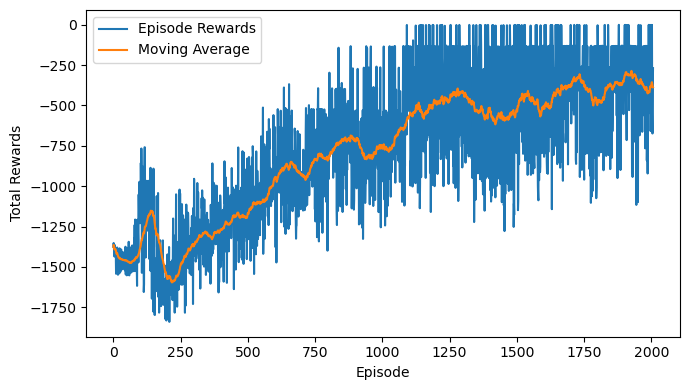

In [9]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-50):(t+1)].mean()
    
    plt.figure(figsize=(7, 4))
    plt.plot(totalrewards, label='Episode Rewards')
    plt.plot(running_avg, label='Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_running_avg(global_rewards)

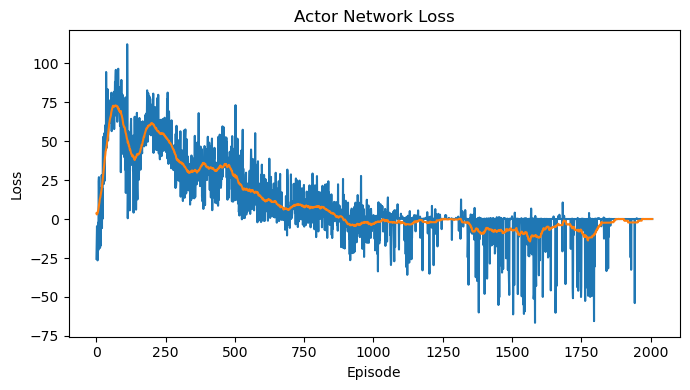

In [10]:
# TODO

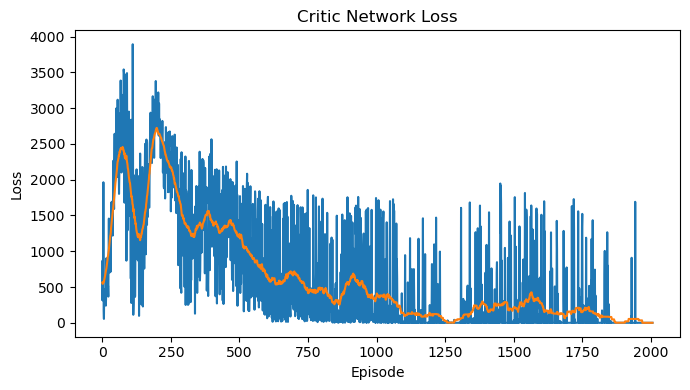

In [11]:
# TODO

## Cost-to-go

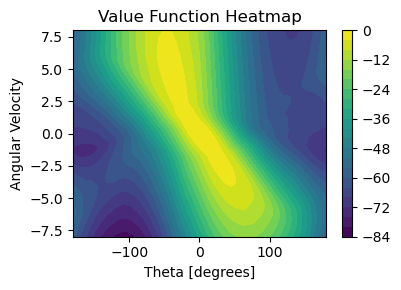

In [12]:
# TODO

## Policy map

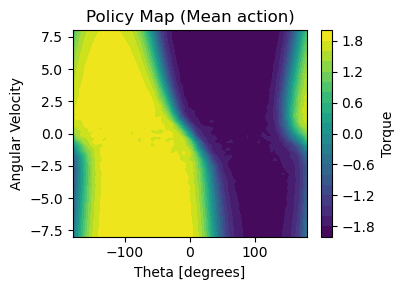

In [13]:
# TODO

## State histogram

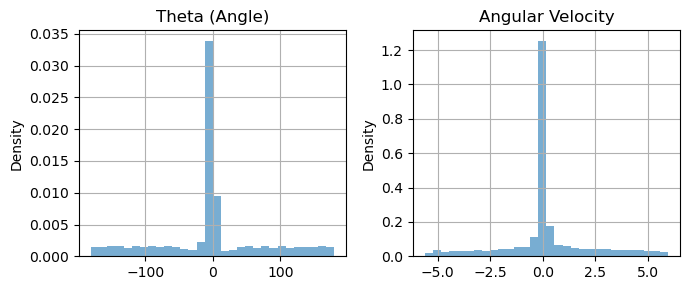

In [15]:
# TODO

## Render the learned policy

In [14]:
from IPython.display import Video, display
import cv2

def render_pendulum(policy_model):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    state, _ = env.reset()

    video_path = "A3C_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(num_timesteps):
        action = policy_model.select_action(state)
        state, reward, done, _, _ = env.step(action)
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        out.write(frame_bgr)
    out.release()
    env.close()
    display(Video(video_path))

render_pendulum(global_ac)